# Chapter 2: A real example. Importing data and setting series

## Data Management


In this example we will show how we can import data from a csv and generate a model with several depositional series.

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_punz5mgg.c:4:19: fatal error: cudnn.h: No such file or directory\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce GTX 1050 Ti (0000:01:00.0)


In this case instead loading a geo_data object directly, we will create one. The main atributes we need to pass are:
- Extent: X min, X max, Y min, Y max, Z min, Z max
- Resolution: X,Y,Z

Additionaly we can pass the address to csv files (GeoModeller3D format) with the data.

In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000,747000,6863000,6930000,-20000, 200],[20, 20, 20],
                         path_o = os.pardir+"/input_data/a_Foliations.csv",
                         path_i = os.pardir+"/input_data/a_Points.csv")

You can visualize the points in 3D (work in progress)

Or a projection in 2D:

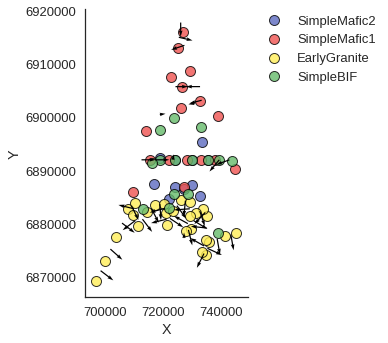

In [3]:
import matplotlib.pyplot as plt
gp.plot_data(geo_data, direction='z')


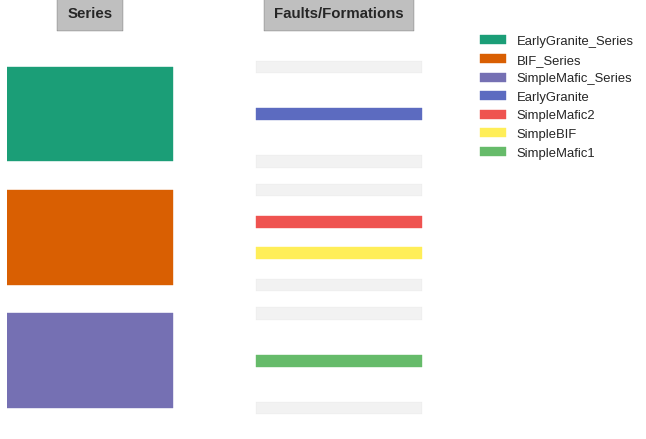

In [4]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                         "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2', 'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

## Computing the model

Now as in the previous chapter we just need to create the interpolator object and compute the model.

In [5]:
#geo_data = gp.select_series(geo_data, ['EarlyGranite_Series'])

In [6]:
interp_data = gp.InterpolatorData(geo_data, theano_optimizer='fast_run', compile_theano=True)#,verbose=['yet_simulated', 'block_series', "scalar_field_iter"])

Compiling theano function...


ERROR (theano.gof.opt): Optimization failure due to: constant_folding
ERROR (theano.gof.opt): node: MakeSlice(NoneConst, NoneConst, TensorConstant{2})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/theano/gof/opt.py", line 2019, in process_node
    replacements = lopt.transform(node)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/opt.py", line 6520, in constant_folding
    v = constant(output.type, storage_map[output][0])
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/type_other.py", line 92, in __init__
    data = slice(data.start, int(data.stop), data.step)
TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

ERROR (theano.gof.opt): Optimization failure due to: constant_folding
ERROR (theano.gof.opt): node: MakeSlice(NoneConst, NoneConst, TensorConstant{2})
ERROR (theano.gof.opt): TRACEBAC

Compilation Done!
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32


In [7]:
new_grid = gp.GridClass()
res = 100

# Create a new grid object with the new resolution
new_grid.create_regular_grid_3d(geo_data.extent,[res, res, res])

# Setting the new grid to the geodata
gp.set_grid(geo_data, new_grid)

interp_data.update_interpolator(geo_data)

In [8]:
interp_data.interpolator.tg.n_formation_float.get_value(), interp_data.interpolator.tg.n_formation.get_value()

(array([ 1.,  2.,  3.,  4.], dtype=float32), array([1, 2, 3, 4], dtype=int32))

In [11]:

lith_block, fault_block = gp.compute_model(interp_data)

In [12]:
interp_data.th_fn.profile.summary()

Function profiling
  Message: ../../gempy/interpolator.py:124
  Time in 0 calls to Function.__call__: 0.000000e+00s
  Total compile time: 3.852803e+01s
    Number of Apply nodes: 158
    Theano Optimizer time: 2.937821e+01s
       Theano validate time: 4.001784e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 9.122876e+00s
       Import time 1.981614e-01s
       Node make_thunk time 9.115677e+00s
           Node forall_inplace,gpu,Looping interfaces}(Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuIncSubtensor{InplaceSet;:int64:}.0, Elemwis

In [ ]:
interp_data.interpolator.tg.n_formations_per_serie.get_value()

In [8]:
np.unique(lith_block[0])

array([ 0.,  1.,  2.,  3.,  4.], dtype=float32)

In [13]:
lith_block[1].min(), lith_block[1].max()

(30.225569, 40.381027)

In [ ]:
interp_data.th_fn.profile.summary()

In [ ]:
interp_data.potential_at_interfaces

Now if we analyse the results we have a 3D array where the axis 0 represent the superposition of the series (potential fields). The color coding is working process yet.

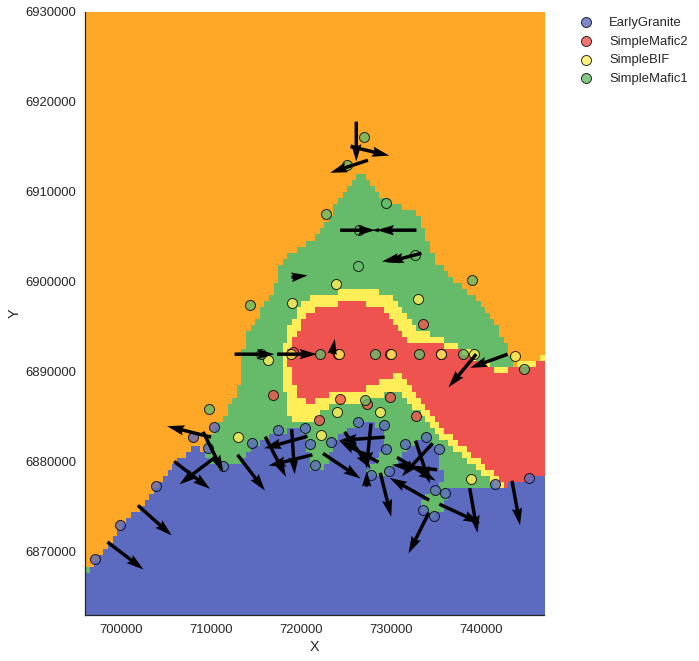

In [31]:
import matplotlib.pyplot as plt

gp.plot_section(geo_data, lith_block[0], -6, plot_data=True, direction='z')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

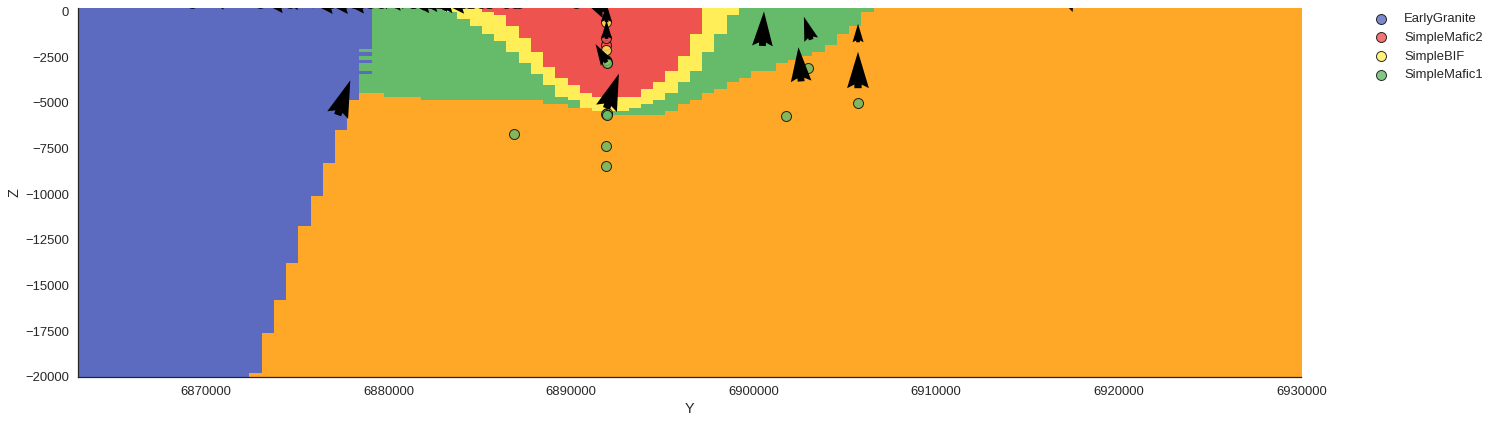

In [33]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0],50, plot_data=True, direction='x')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

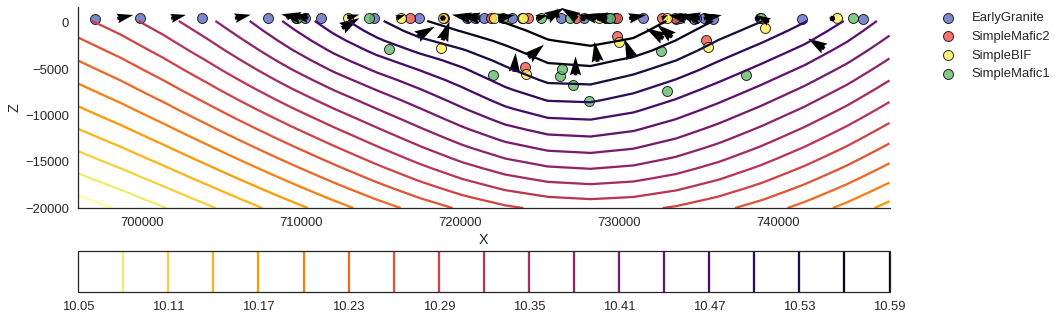

In [10]:
gp.plot_scalar_field(geo_data, lith_block[1], 11, cmap='inferno_r', N=20)
import matplotlib.pyplot as plt
plt.colorbar(orientation='horizontal')

And the axis 2 keeps the faults network that in this model since there is not faults does not represent anything.

Additionally with can export the blocks to vtk in order to visualize them in Paraview. We are working in visualization in place as well.

In [ ]:
vertices, simplices = gp.get_surfaces(interp_data, lith_block[1], None, original_scale=False)

# np.save('ver_sand', vertices)
# np.save('sim_sand', simplices)

In [ ]:
gp.export_to_vtk(geo_data, lith_block=lith_block[0], vertices=vertices, simplices=simplices)

In [ ]:
gp.plot_surfaces_3D_real_time(interp_data, vertices, simplices, alpha=1)